# Collaborative filtering with embedding

The goal of this notebook is to review [lesson 5 of fast.ai courses](http://forums.fast.ai/t/wiki-lesson-5/9403) ([Note](https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-5-dd904506bee8))

I will try to duplicate what he has on his lesson's notebook without looking at it (trying my best not to). Also I will use a larger dataset to train + add some of my experiments.

Collab filtering model + embedding layers will be built entirely with pytorch and will be trained (or fitted) using fast.ai framework so it's not really 'from scratch' like previous notebook I have in this repository. However, the core of this model is [pytorch neural network](https://github.com/anhquan0412/basic_model_scratch/blob/master/NN_pytorch.ipynb) and [gradient descent optimization](https://github.com/anhquan0412/basic_model_scratch/blob/master/linear_regression.ipynb) which I already covered.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.learner import * # fastai fit/predict function
from fastai.column_data import * # fastai columnar (structred) data loader
PATH = Path('data/large_ds/ml-latest')
# PATH = Path('data/large_ds/ml-latest-small')

Dataset contains 26+ million ratings and 753000+ tag applications across 45000+ movies
```
wget http://files.grouplens.org/datasets/movielens/ml-latest.zip
```

In [ ]:
!ls data/large_ds/ml-latest

In [3]:
ratings = pd.read_csv(PATH/'ratings.csv')
# movies= pd.read_csv(PATH/'movies.csv')

In [5]:
ratings.tail()

,userId,movieId,rating,timestamp
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990
26024288,270896,71878,2.0,1257031858


## Simple EDA 

In [6]:

#top 10 users with most reviews and their average ratings
top=ratings.groupby(['userId']).rating.agg(['mean','count']).reset_index()
top_users = top.sort_values('count',ascending=False).head(10).reset_index().drop('index',axis=1)
top_users

,userId,mean,count
0,45811,3.198758,18276
1,8659,3.278424,9279
2,270123,2.597473,7638
3,179792,3.208317,7515
4,228291,3.220175,7410
5,243443,1.576028,6320
6,98415,2.804972,6094
7,229879,3.498257,6024
8,98787,2.438080,5814
9,172224,3.747851,5701


In [7]:
#top 10 most-reviewed movies w and their average ratings
top=ratings.groupby(['movieId']).rating.agg(['mean','count']).reset_index()
top_movies=top.sort_values('count',ascending=False).head(10).reset_index().drop('index',axis=1)

In [8]:
top_movies.merge(movies,on='movieId',how='left')

,movieId,mean,count,title,genres
0,356,4.052926,91921,Forrest Gump (1994),Comedy|Drama|Romance|War
1,318,4.429015,91082,"Shawshank Redemption, The (1994)",Crime|Drama
2,296,4.169975,87901,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,4.152246,84078,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,4.154098,77960,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,260,4.132299,77045,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,480,3.660238,74355,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,527,4.266531,67662,Schindler's List (1993),Drama|War
8,110,4.016057,66512,Braveheart (1995),Action|Drama|War
9,1,3.888157,66008,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [10]:
crosstab = pd.merge(ratings,top_users,how='inner',on='userId')

In [11]:
crosstab = pd.merge(crosstab,top_movies,how='inner',on='movieId')

In [12]:
pd.crosstab(crosstab.userId, crosstab.movieId, crosstab.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,593,2571
userId,,,,,,,,,,
8659,4.0,5.0,4.0,4.5,4.0,4.0,3.0,4.0,4.0,4.0
45811,4.0,3.5,4.0,4.5,4.5,3.5,4.0,4.5,4.0,4.0
98415,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.5,4.0
98787,4.0,4.0,3.0,5.0,5.0,2.0,2.5,3.5,4.0,4.0
172224,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
179792,5.0,4.0,5.0,5.0,4.5,4.5,4.0,5.0,5.0,5.0
228291,3.0,4.0,4.0,4.0,4.5,3.0,4.0,4.0,4.0,4.5
229879,5.0,1.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0
243443,5.0,3.5,5.0,5.0,5.0,2.0,3.5,5.0,2.0,5.0


# Embedding

The idea is to use a vector of size n_factors to describe each movie and each user. I.e movies can be categorized (by genre: action, romance ...), so are users. Thus we can represent all users with a matrix with shape (n_users,n_factors) and all movies with matrix with shape (n_movies,n_factors). From here we can build a (n_users,n_movies) matrix by dot-producting these 2 matrices and optimize loss with gradient descent

In [4]:
#build a movie rating dataset
from torch.utils.data import Dataset

In [5]:
def get_val_idxs(n,val_perc):
    np.random.seed(42)
    val_size = int(n*val_perc)
    return np.random.permutation(n)[:val_size]

In [6]:
val_idxs = get_val_idxs(len(ratings),.2)

### Create fastai model data obj

In [ ]:
# fast.ai classes
# DO NOT RUN THIS CELL. THIS IS ONLY FOR TAKING NOTE AND ADD COMMENTS
class CollabFilterDataset(Dataset):
    def __init__(self, path, user_col, item_col, ratings):
        self.ratings,self.path = ratings.values.astype(np.float32),path
        self.n = len(ratings)
        (self.uniq_users,self.user2idx,self.user_col,self.n_users) = self.proc_col(user_col)
        (self.uniq_items,self.item2idx,self.item_col,self.n_items) = self.proc_col(item_col)
        self.min_score,self.max_score = min(ratings),max(ratings)
        self.cols = [self.user_col,self.item_col,self.ratings]
        
    def get_learner(self, n_factors, val_idxs, bs, **kwargs):
        return CollabFilterLearner(self.get_data(val_idxs, bs), self.get_model(n_factors), **kwargs)
    
    
    
    def get_data(self, val_idxs, bs): # return collab-filter DATA LOADER
        # split val and trn data # val shape = [n_cols including rating,n_val]. trn shape = [n_cols including rating, n_val]
        val, trn = zip(*split_by_idx(val_idxs, *self.cols))
        return ColumnarModelData(self.path, PassthruDataset(*trn), PassthruDataset(*val), bs)
    
    def get_model(self, n_factors):
        model = EmbeddingDotBias(n_factors, self.n_users, self.n_items, self.min_score, self.max_score)
        return CollabFilterModel(to_gpu(model))


class PassthruDataset(Dataset):
    def __init__(self,*args, is_reg=True, is_multi=False):
        *xs,y=args #xs shape: [n_features not including rating y,n_rows]
        self.xs,self.y = xs,y
        self.is_reg = is_reg
        self.is_multi = is_multi

    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return [o[idx] for o in self.xs] + [self.y[idx]] # get each row of dataset including y
    
# fast.ai model data for training
class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)
        

In [25]:
# results of split_by_idx function
# [(feature 1 on val set, feature 1 on train set),..., (y on val, y on train)]
temp=[([1,2,3],[4,5]),([6,7,8],[9,10]),([True,True,False],[False,True])]
val,trn = zip(*temp)
print(val)
print(trn)
print('-'*10)
pd = PassthruDataset(*val)
pd[0]

([1, 2, 3], [6, 7, 8], [True, True, False])
([4, 5], [9, 10], [False, True])
----------


[1, 6, True]

In [7]:
cf = CollabFilterDataset.from_csv(PATH, 'ratings.csv', 'userId', 'movieId', 'rating')

In [8]:
# run the default fast.ai collab-filtering model (EmbeddingBias)
n_factors=50
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)
learn.fit(1e-2, 2, wds=1e-4, cycle_len=1)

epoch      trn_loss   val_loss                                                 
    0      0.774639   0.803391  
    1      0.721318   0.783338                                                 



[array([0.78334])]

In [8]:
# full dataset run

n_factors=50
bs = 1024*20
learn = cf.get_learner(n_factors, val_idxs, bs, opt_fn=optim.Adam)
learn.fit(1e-2, 2, wds=1e-4, cycle_len=1)

epoch      trn_loss   val_loss                                 
    0      0.908019   0.906998  
    1      0.907035   0.90637                                  



[array([0.90637])]

In [14]:
pred = learn.predict() #predict on validation set
y_val = learn.data.val_y

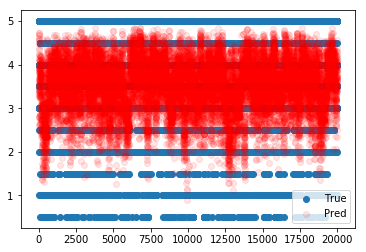

In [21]:
plt.scatter(range(0,len(y_val)),y_val,label='True')
plt.scatter(range(0,len(pred)),pred,c='r',alpha=0.1,label='Pred')
plt.legend()
plt.show()

In [23]:
pd.Series(y_val).describe()

count    20000.000000
mean         3.551025
std          1.060102
min          0.500000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
dtype: float64

# Build collab-filter model from scratch (kinda, we will use only pytorch)

### Model 1: Multiplying 2 embedding matrices

In [55]:
bs=64
wd=1e-4
n_factors=50

In [9]:
def plot_pred(pred,y_val,alpha=0.1):
    plt.scatter(range(0,len(y_val)),y_val,label='True')
    plt.scatter(range(0,len(pred)),pred,c='r',alpha=alpha,label='Pred')
    plt.legend()
    plt.show()

In [79]:
class EmbeddingMult(nn.Module):
    def __init__(self, n_factors,n_users,n_movies):
        super().__init__()
        self.user_emb = nn.Embedding(n_users,n_factors)
        self.movie_emb = nn.Embedding(n_movies,n_factors)
        self.user_emb.weight.data.uniform_(0,0.05) #uniformly distributed number between 0 and .05
        self.movie_emb.weight.data.uniform_(0,0.05)
        
    def forward(self,users,movies):
        u = self.user_emb(users) # (bs,n_factor)
        m = self.movie_emb(movies)# (bs,n_factor)
        return (u*m).sum(1)
        

In [139]:
cf = CollabFilterDataset.from_csv(PATH, 'ratings.csv', 'userId', 'movieId', 'rating')

In [10]:
class BasicModel():
    def __init__(self,model,name='unnamed'): self.model,self.name = model,name 
    def get_layer_groups(self, do_fc=False): return children(self.model)
class CollabFilterModel(BasicModel): 
    #inherit BasicModel to override get_layer_groups
    # get_layer_groups are needed for LayerOptimizer class, which allows setting differential learning rates for 
    # different parts of models. Might not need for collab-filtering
    def get_layer_groups(self): return self.model # print model architecture

In [102]:
model = CollabFilterModel(EmbeddingMult(n_factors,cf.n_users,cf.n_items))

In [103]:
learner = CollabFilterLearner(cf.get_data(val_idxs,bs),model,opt_fn=optim.Adam)

In [91]:
learner.model

EmbeddingMult(
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
)

In [99]:
learner.fit(1e-2, 3, wds=1e-4, cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss                                                 
    0      1.649622   1.555017  
    1      1.521423   1.579968                                                 
    2      0.908356   1.319305                                                 
    3      1.773395   1.842668                                                 
    4      1.084354   1.543048                                                 
    5      0.59796    1.403753                                                 
    6      0.342687   1.393899                                                 



[array([1.3939])]

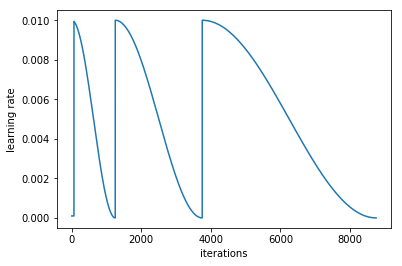

In [100]:
learner.sched.plot_lr()

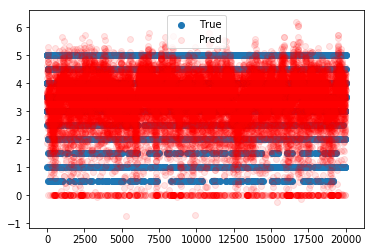

In [76]:
plot_pred(learner.predict(),learner.data.val_y)

Few predictions falls outside of rating range [0.5,5]. We will try to clip the outputs within this rank

In [11]:
class EmbeddingMult(nn.Module):
    def __init__(self, n_factors,n_users,n_movies):
        super().__init__()
        self.user_emb = nn.Embedding(n_users,n_factors)
        self.movie_emb = nn.Embedding(n_movies,n_factors)
        self.user_emb.weight.data.uniform_(0,0.05) #uniformly distributed number between 0 and .05
        self.movie_emb.weight.data.uniform_(0,0.05)
        
    def forward(self,users,movies):
        u = self.user_emb(users) # (bs,n_factor)
        m = self.movie_emb(movies)# (bs,n_factor)
        oup= (u*m).sum(1)
        return F.sigmoid(oup)*(5-0.5) + 0.5

In [109]:
model = CollabFilterModel(EmbeddingMult(n_factors,cf.n_users,cf.n_items))

learner = CollabFilterLearner(cf.get_data(val_idxs,bs),model,opt_fn=optim.Adam)

learner.model

# learner.fit(1e-2, 3, wds=1e-4, cycle_len=1,cycle_mult=2)

EmbeddingMult(
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
)

In [107]:
learner.fit(1e-2, 3, wds=1e-4, cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss                                                 
    0      0.902583   0.89179   
    1      0.9084     0.880569                                                 
    2      0.536571   0.830401                                                 
    3      0.852574   0.959802                                                 
    4      0.547831   0.879781                                                 
    5      0.347229   0.860583                                                 
    6      0.202606   0.862896                                                 



[array([0.8629])]

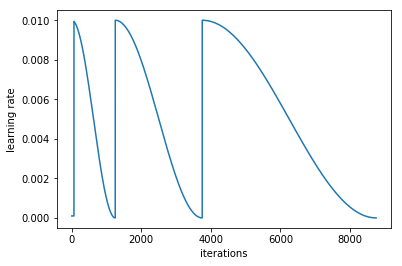

In [108]:
learner.sched.plot_lr()

In [110]:
learner.fit(1e-2, 2, wds=1e-4, cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss                                                 
    0      0.901693   0.885552  
    1      0.890093   0.884227                                                 
    2      0.539785   0.835585                                                 



[array([0.83559])]

It's better, but we can see a sign of overfitting.

### Model 2: Multiplying 2 embedding matrices with bias

In [128]:
# torch embedding examples
temp = nn.Embedding(10,1)
v = V(np.array([0,0,1,2]))
print(temp(v))
print(temp(v).squeeze())

Variable containing:
 0.6502
 0.6502
-0.6878
-0.5305
[torch.FloatTensor of size 4x1]

Variable containing:
 0.6502
 0.6502
-0.6878
-0.5305
[torch.FloatTensor of size 4]



In [130]:
# only accepts idx between 0 and 9 for embedding size (10,1). 
# This is why we have to convert user_id and movie_id to indices between 0 and n_movies or n_users 
v = V(np.array([10]))
print(temp(v))

RuntimeError: index out of range at c:\anaconda2\conda-bld\pytorch_1519496000060\work\torch\lib\th\generic/THTensorMath.c:277

In [12]:

class EmbeddingMultWithBias(nn.Module):
    def __init__(self, n_factors,n_users,n_movies,min_w=-0.05,max_w=.05,min_score=0.5,max_score=5):
        super().__init__()
        self.user_bias = nn.Embedding(n_users,1)
        self.user_emb = nn.Embedding(n_users,n_factors)
        
        self.movie_bias = nn.Embedding(n_movies,1)
        self.movie_emb = nn.Embedding(n_movies,n_factors)
        
        self.user_emb.weight.data.uniform_(min_w,max_w) #uniformly distributed number between 0 and .05
        self.movie_emb.weight.data.uniform_(min_w,max_w)
        self.user_bias.weight.data.uniform_(min_w,max_w)
        self.movie_bias.weight.data.uniform_(min_w,max_w)
        
        self.low=min_score
        self.high=max_score
        
    def forward(self,users,movies):
        u = self.user_emb(users) # (bs,n_factor)
        m = self.movie_emb(movies)# (bs,n_factor)
        
        ub = self.user_bias(users)
        mb = self.movie_bias(movies)
        
        oup= (u*m).sum(1) + ub.squeeze() + mb.squeeze()
        return F.sigmoid(oup)*(self.high-self.low) + self.low

In [121]:
model = CollabFilterModel(EmbeddingMultWithBias(n_factors,cf.n_users,cf.n_items))

learner = CollabFilterLearner(cf.get_data(val_idxs,bs),model,opt_fn=optim.Adam)

learner.model

# learner.fit(1e-2, 3, wds=1e-4, cycle_len=1,cycle_mult=2)

EmbeddingMultWithBias(
  (user_bias): Embedding(671, 1)
  (user_emb): Embedding(671, 50)
  (movie_bias): Embedding(9066, 1)
  (movie_emb): Embedding(9066, 50)
)

In [119]:
learner.fit(1e-2, 3, wds=1e-4, cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss                                                 
    0      0.802582   0.805643  
    1      0.795883   0.778481                                                 
    2      0.471222   0.766023                                                 
    3      0.742809   0.838536                                                 
    4      0.481364   0.796326                                                 
    5      0.322798   0.782744                                                 
    6      0.1827     0.783456                                                 



[array([0.78346])]

In [122]:
learner.fit(1e-2, 2, wds=1e-4, cycle_len=1,cycle_mult=3)

epoch      trn_loss   val_loss                                                 
    0      0.801996   0.802115  
    1      0.777857   0.799769                                                 
    2      0.564424   0.769242                                                 
    3      0.292378   0.770617                                                 



[array([0.77062])]

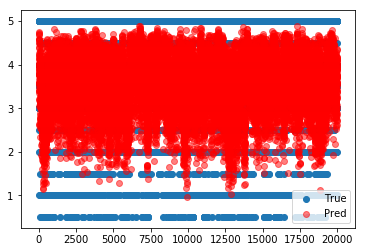

In [133]:
plot_pred(learner.predict(),learner.data.val_y,alpha=0.5)

In [134]:
pd.Series(learner.data.val_y).value_counts()

4.0    5807
3.0    3862
5.0    3062
3.5    2155
4.5    1537
2.0    1435
2.5     915
1.0     683
1.5     325
0.5     219
dtype: int64

Significant improvements

### Model 3: Neural net

In [13]:

class EmbeddingNN(nn.Module):
    def __init__(self, n_factors,n_users,n_movies,n_hiddens,drops,emb_drop,min_w=-0.05,max_w=.05,min_score=0.5,max_score=5):
        super().__init__()
        self.user_emb = nn.Embedding(n_users,n_factors)
        
        self.movie_emb = nn.Embedding(n_movies,n_factors)
        
        self.user_emb.weight.data.uniform_(min_w,max_w) #uniformly distributed number between 0 and .05
        self.movie_emb.weight.data.uniform_(min_w,max_w)
        
        self.low=min_score
        self.high=max_score
        
        n_hiddens = [n_factors*2] + n_hiddens
        
        self.weights = nn.ModuleList([nn.Linear(n_hiddens[i],n_hiddens[i+1]) for i in range(len(n_hiddens)-1)])
        self.outp = nn.Linear(n_hiddens[-1],1)
        self.bns = nn.ModuleList([nn.BatchNorm1d(l) for l in n_hiddens[1:]])
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        
        self.emb_drop = nn.Dropout(emb_drop)
        
    def forward(self,users,movies):
        u = self.user_emb(users) # (bs,n_factor)
        m = self.movie_emb(movies)# (bs,n_factor)
        x = torch.cat([u,m],1) # (bs,n_factor*2)
        x = self.emb_drop(x) # embedding dropout
        for w,bn,dr in  zip(self.weights,self.bns,self.drops):
            x = F.relu(w(x))
            x = bn(x)
            x = dr(x)
        
        x = self.outp(x)

        x= F.sigmoid(x)*(self.high-self.low) + self.low
        return x

In [152]:
nn_model = EmbeddingNN(n_factors,cf.n_users,cf.n_items,[50],[.1],.05)
model = CollabFilterModel(nn_model)
learner = CollabFilterLearner(cf.get_data(val_idxs,bs),model,opt_fn=optim.Adam)

learner.model


EmbeddingNN(
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
  (weights): ModuleList(
    (0): Linear(in_features=100, out_features=50, bias=True)
  )
  (outp): Linear(in_features=50, out_features=1, bias=True)
  (bns): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  )
  (drops): ModuleList(
    (0): Dropout(p=0.1)
  )
  (emb_drop): Dropout(p=0.05)
)

In [153]:
learner.fit(1e-2, 3, wds=1e-4, cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss                                                 
    0      0.807222   0.80005   
    1      0.804519   0.805894                                                 
    2      0.732739   0.774819                                                 
    3      0.823763   0.799164                                                 
    4      0.795089   0.785584                                                 
    5      0.73103    0.765407                                                 
    6      0.637968   0.77143                                                  



[array([0.77143])]

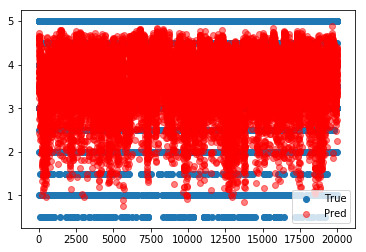

In [154]:
plot_pred(learner.predict(),learner.data.val_y,alpha=0.5)

The performance is slightly better, and our model has stable loss and differences between train and val MSE loss are not much different anymore. However, the model does not predict well ratings close to 5 and 0.5. Since the NN model is a bit more complex, let's adjust this boundary

In [155]:
nn_model = EmbeddingNN(n_factors,cf.n_users,cf.n_items,[50],[.1],.05,min_score=0.3,max_score=5.3)
model = CollabFilterModel(nn_model)
learner = CollabFilterLearner(cf.get_data(val_idxs,bs),model,opt_fn=optim.Adam)

learner.model


EmbeddingNN(
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
  (weights): ModuleList(
    (0): Linear(in_features=100, out_features=50, bias=True)
  )
  (outp): Linear(in_features=50, out_features=1, bias=True)
  (bns): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  )
  (drops): ModuleList(
    (0): Dropout(p=0.1)
  )
  (emb_drop): Dropout(p=0.05)
)

In [156]:
learner.fit(1e-2, 4, wds=1e-4, cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss                                                 
    0      0.807827   0.799249  
    1      0.818132   0.799678                                                 
    2      0.710604   0.776296                                                 
    3      0.821519   0.800566                                                 
    4      0.742796   0.777877                                                 
    5      0.716605   0.770401                                                 
    6      0.65807    0.774417                                                 
    7      0.799611   0.794949                                                 
    8      0.778868   0.794231                                                 
    9      0.772016   0.783783                                                 
    10     0.743567   0.775645                                                 
    11     0.71844    0.772887                                                 
    12 

[array([0.78159])]

We can stop the model at epoch 5 with val loss .770

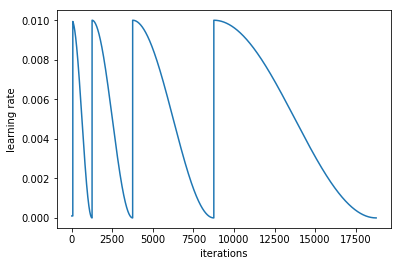

In [157]:
learner.sched.plot_lr()

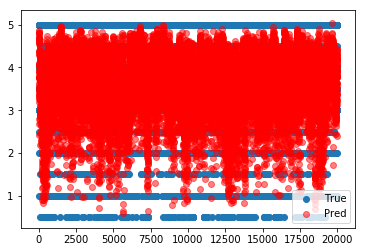

In [158]:
plot_pred(learner.predict(),learner.data.val_y,alpha=0.5)

In [ ]:
# run on full dataset
cf = CollabFilterDataset.from_csv(PATH, 'ratings.csv', 'userId', 'movieId', 'rating')

In [19]:
# run on full dataset

bs = 1024*20
nn_model = EmbeddingNN(n_factors,cf.n_users,cf.n_items,[50],[.1],.05,min_score=0.3,max_score=5.3).cuda()
model = CollabFilterModel(nn_model)
learner = CollabFilterLearner(cf.get_data(val_idxs,bs),model,opt_fn=optim.Adam)

learner.model


EmbeddingNN(
  (user_emb): Embedding(270896, 50)
  (movie_emb): Embedding(45115, 50)
  (weights): ModuleList(
    (0): Linear(in_features=100, out_features=50, bias=True)
  )
  (outp): Linear(in_features=50, out_features=1, bias=True)
  (bns): ModuleList(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  )
  (drops): ModuleList(
    (0): Dropout(p=0.1)
  )
  (emb_drop): Dropout(p=0.05)
)

In [20]:
learner.fit(1e-2, 3, wds=1e-4, cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.761665   0.747284  
    1      0.789835   0.776027                                 
    2      0.741225   0.72403                                  
    3      0.798147   0.784165                                 
    4      0.781635   0.768394                                 
    5      0.751639   0.734078                                 
    6      0.721329   0.709168                                 



[array([0.70917])]

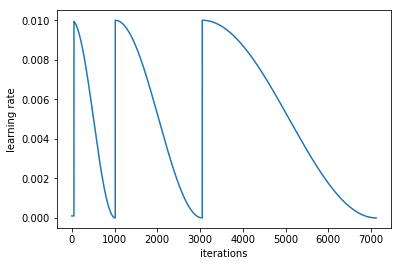

In [21]:
learner.sched.plot_lr()

In [22]:
learner.fit(0.001, 1, wds=1e-4, cycle_len=3)

epoch      trn_loss   val_loss                                 
    0      0.722849   0.709267  
    1      0.708016   0.695586                                 
    2      0.687432   0.691548                                 



[array([0.69155])]

With only 10 epochs, we can achieve such a good MSE loss of .69 with little hyperparameter tuning. I will stop here, however this model can achieve better loss.

# Improvements

Since ratings are categorical values (6 classes, .5,1,1.5,2,...,5), we might achieve better performance if we change the model to classification

We can also tune drop out/ embedding dropout, add more hidden layers. These steps belong to hyperparameter tuning process and will be discussed in another time.